In [ ]:
pip install wfdb

In [ ]:
!wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/

--2024-05-17 06:54:41--  https://physionet.org/files/mitdb/1.0.0/
Resolving physionet.org (physionet.org)... 18.13.52.205
Connecting to physionet.org (physionet.org)|18.13.52.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘physionet.org/files/mitdb/1.0.0/index.html’

physionet.org/files     [ <=>                ]  22.86K  --.-KB/s    in 0.02s   

Last-modified header missing -- time-stamps turned off.
2024-05-17 06:54:42 (937 KB/s) - ‘physionet.org/files/mitdb/1.0.0/index.html’ saved [23410]

Loading robots.txt; please ignore errors.
--2024-05-17 06:54:42--  https://physionet.org/robots.txt
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK

    The file is already fully retrieved; nothing to do.

--2024-05-17 06:54:42--  https://physionet.org/files/mitdb/1.0.0/mitdbdir/
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 304 Not Modified

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import wfdb
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.model_selection import train_test_split
from scipy.signal import butter, lfilter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

In [ ]:
# Function to load a record and its annotations
def load_record(record_number, data_path=''):
    record = wfdb.rdrecord(f'{data_path}{record_number}')
    annotation = wfdb.rdann(f'{data_path}{record_number}', 'atr')
    return record, annotation

In [ ]:

# Function to apply bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

In [ ]:
# Load a sample record (e.g., record 100)
record_number = 100
data_path = '/content/physionet.org/files/mitdb/1.0.0/'  # Adjust this to the correct path
record, annotation = load_record(record_number, data_path)

In [ ]:
# Apply bandpass filter to remove noise (0.5-50 Hz)
fs = 360  # Sampling frequency
filtered_signal = bandpass_filter(record.p_signal[:, 0], 0.5, 50, fs)

In [ ]:
# Segment the signal into 1-second windows
segment_length = fs  # 1 second
segments = [filtered_signal[i:i + segment_length] for i in range(0, len(filtered_signal) - segment_length, segment_length)]
segments = np.array(segments)

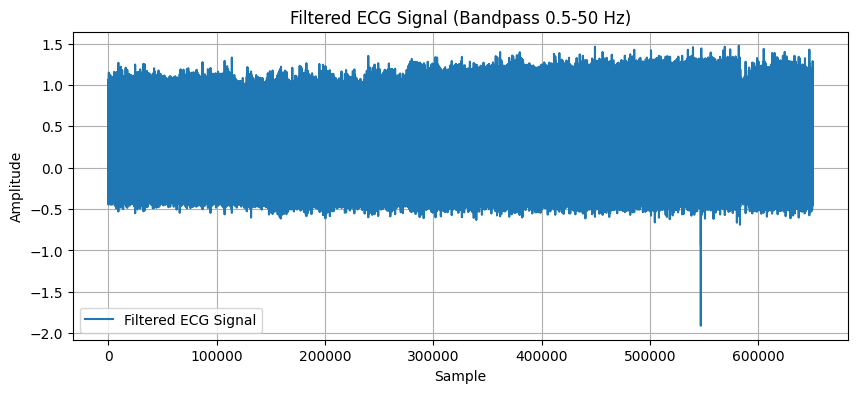

In [ ]:
# Plot the filtered ECG signal
plt.figure(figsize=(10, 4))
plt.plot(filtered_signal, label='Filtered ECG Signal')
plt.title('Filtered ECG Signal (Bandpass 0.5-50 Hz)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Create labels based on annotations (this is a simplified example)
labels = np.zeros(len(segments))  # You should use actual labels from annotations

In [ ]:
# Convert to DataFrame
data = pd.DataFrame(segments)
data['label'] = labels

In [ ]:
data.shape

(1805, 361)

In [ ]:
# Split data into features and labels
x = data.iloc[:, :-1].values  # Features (ECG segments)
y = data.iloc[:, -1].values  # Labels

In [ ]:
# One-hot encode the labels
encoder = OneHotEncoder()

In [ ]:
y = encoder.fit_transform(y.reshape(-1, 1)).toarray()

In [ ]:
x_train, y_train, x_test, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)

In [ ]:
# Example data (replace these with your actual data)
x_train = np.random.randn(1444, 10)  # Example feature data with 10 features
y_train = np.random.randint(0, 2, size=(1444, 1))  # Example labels

x_test = np.random.randn(361, 10)  # Example feature data with 10 features
y_test = np.random.randint(0, 2, size=(361, 1))  # Example labels

# Print original shapes
print("Original shapes:")
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

# Scale the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Print shapes after scaling
print("\nShapes after scaling:")
print("x_train_scaled shape:", x_train_scaled.shape)
print("x_test_scaled shape:", x_test_scaled.shape)


Original shapes:
x_train shape: (1444, 10)
x_test shape: (361, 10)

Shapes after scaling:
x_train_scaled shape: (1444, 10)
x_test_scaled shape: (361, 10)


In [ ]:
# Define the CNN model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


46/46 [==============================] - 2s 9ms/step - loss: 0.0000e+00 - accuracy: 0.5076 - val_loss: 0.0000e+00 - val_accuracy: 0.4958
Epoch 2/10
46/46 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.5076 - val_loss: 0.0000e+00 - val_accuracy: 0.4958
Epoch 3/10
46/46 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.5076 - val_loss: 0.0000e+00 - val_accuracy: 0.4958
Epoch 4/10
46/46 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.5076 - val_loss: 0.0000e+00 - val_accuracy: 0.4958
Epoch 5/10
46/46 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.5076 - val_loss: 0.0000e+00 - val_accuracy: 0.4958
Epoch 6/10
46/46 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.5076 - val_loss: 0.0000e+00 - val_accuracy: 0.4958
Epoch 7/10
46/46 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.5076 - val_loss: 0.0000e+0

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')


12/12 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.4958
Accuracy: 49.58%


In [ ]:
model.save('ecg_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#**Prediction on new data**

In [ ]:
#preparing the input data
new_record_number = '230'
new_data_path = '/content/physionet.org/files/mitdb/1.0.0/'
record, annotation = load_record(new_record_number, new_data_path)

In [ ]:
# Apply bandpass filter to remove noise (same filter parameters as before)
fs = 360  # Sampling frequency
filtered_signal = bandpass_filter(record.p_signal[:, 0], 0.5, 50, fs)

In [ ]:
# Segment the signal into 1-second windows (same segment length as before)
segment_length = 10  # 1 second
segments = [filtered_signal[i:i + segment_length] for i in range(0, len(filtered_signal) - segment_length, segment_length)]
segments = np.array(segments)

In [ ]:
# Standardize the segments using the same scaler as used during training
scaler = StandardScaler()
segments = scaler.fit_transform(segments)

In [ ]:
# Reshape for CNN input
segments = segments.reshape(segments.shape[0], segments.shape[1], 1)

# **Loading the trained model**

In [ ]:
model = tf.keras.models.load_model('ecg_model.h5')

# **Time to make prediction**

In [ ]:
predictions = model.predict(segments)

2032/2032 [==============================] - 4s 2ms/step


# **Interpreting the Prediction**

In [ ]:
# Map predictions to original labels
label_map = {0: 'Normal beat', 1: 'Atrial Premature Contraction (APC) ', 2: 'Ventricular Premature Contraction (VPC)'}
predicted_labels_indices = np.argmax(predictions, axis=1)
predicted_labels = [label_map[idx] for idx in predicted_labels_indices]

In [ ]:
# Print the predictions
for i, label in enumerate(predicted_labels):
    print(f'Segment {i + 1}: {label}')

Streaming output truncated to the last 5000 lines.
Segment 60000: Normal beat
Segment 60001: Normal beat
Segment 60002: Normal beat
Segment 60003: Normal beat
Segment 60004: Normal beat
Segment 60005: Normal beat
Segment 60006: Normal beat
Segment 60007: Normal beat
Segment 60008: Normal beat
Segment 60009: Normal beat
Segment 60010: Normal beat
Segment 60011: Normal beat
Segment 60012: Normal beat
Segment 60013: Normal beat
Segment 60014: Normal beat
Segment 60015: Normal beat
Segment 60016: Normal beat
Segment 60017: Normal beat
Segment 60018: Normal beat
Segment 60019: Normal beat
Segment 60020: Normal beat
Segment 60021: Normal beat
Segment 60022: Normal beat
Segment 60023: Normal beat
Segment 60024: Normal beat
Segment 60025: Normal beat
Segment 60026: Normal beat
Segment 60027: Normal beat
Segment 60028: Normal beat
Segment 60029: Normal beat
Segment 60030: Normal beat
Segment 60031: Normal beat
Segment 60032: Normal beat
Segment 60033: Normal beat
Segment 60034: Normal beat
Segm